Legend said that a large NN can easily overfit, especially when you have small data. Is it true?

In [1]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
import random
random.seed(0)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Concatenate, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)
from sklearn.ensemble import GradientBoostingRegressor

imperium-sm.hep.caltech.edu  Sun Aug  4 14:26:31 2019  418.67
[0] GeForce GTX 1080 | 38'C,   2 % |   666 /  8119 MB | 3038(655M)
[1] GeForce GTX 1080 | 23'C,   0 % |  8100 /  8119 MB | qnguyen(8089M)
[2] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[3] GeForce GTX 1080 | 27'C,   0 % |     1 /  8119 MB |
[4] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[5] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |


Using TensorFlow backend.


# Dataset

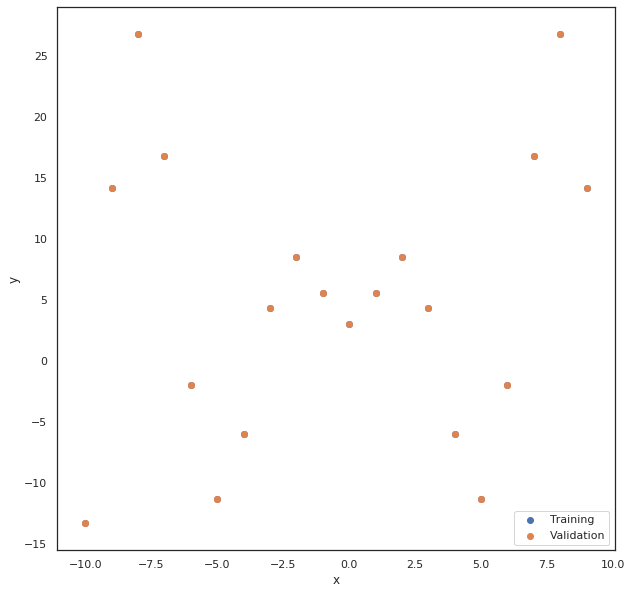

Number of data points:  20


In [2]:
x = np.arange(-10,10, step=1)
y = 3+3*x * np.sin(x)
yval = y  # + np.random.normal(0,np.absolute(x/3))
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
plt.figure(figsize=(10,10))
plt.scatter(x,y,label='Training')
plt.scatter(x,yval,label='Validation')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

Note that the training and validation datasets are intentionally set to be identical.

# A Big Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             20000     
_________________________________________________________________
dense_2 (Dense)              (None, 10000)             100010000 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10001     
Total params: 100,040,001
Trainable params: 100,040,001
Non-trainable params: 0
_________________________________________________________________
Train on 20 samples, validate on 20 samples
Epoch 1/500
20/20 [==============================] - 3s 147ms/step - loss: 162.8665 - val_loss: 127.6625
Epoch 2/500
20/20 [==============================] - 1s 38ms/step - loss: 157.7328 - val_loss: 125.8290
Epoch 3

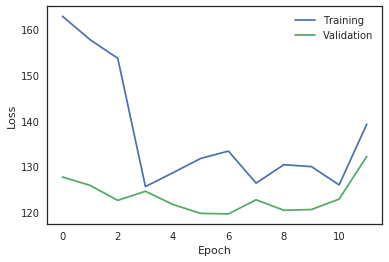

In [3]:
inputs = Input(shape=(1,))
hidden = Dense(10000, activation='relu')(inputs)
hidden = Dense(10000, activation='relu')(hidden)
#hidden = Dense(10, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=500, batch_size=2, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


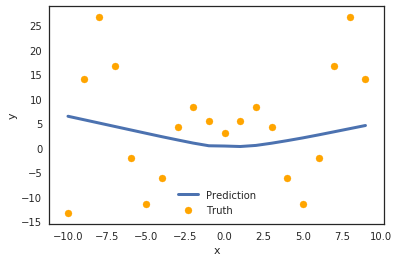

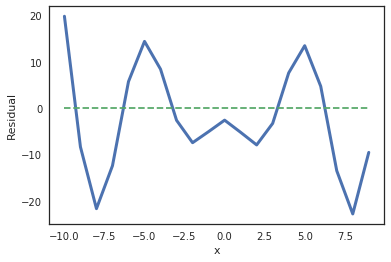

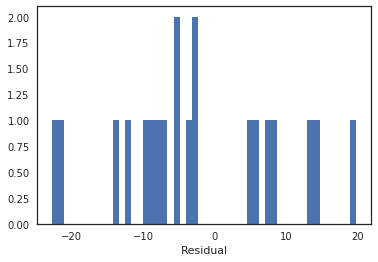

In [4]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

A neural net of 100M parameters can't overfit 20 data points!! Is it because of the architecture? Let's try a deeper one.

# A Deeply Big Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10000)             20000     
_________________________________________________________________
dense_5 (Dense)              (None, 10000)             100010000 
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              10001000  
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1001      
Total params: 111,033,001
Trainable params: 111,033,001
Non-trainable params: 0
______________________________________________________________

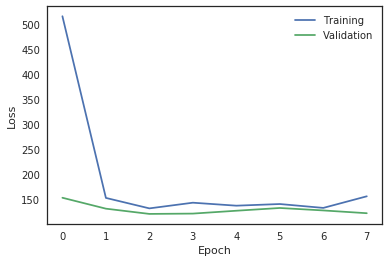

In [5]:
inputs = Input(shape=(1,))
hidden = Dense(10000, activation='relu')(inputs)
hidden = Dense(10000, activation='relu')(hidden)
hidden = Dense(1000, activation='relu')(hidden)
hidden = Dense(1000, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=500, batch_size=2, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

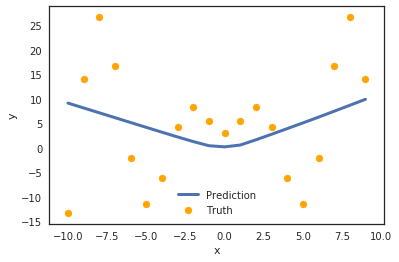

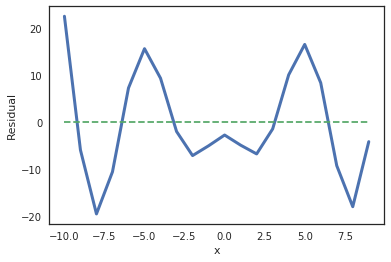

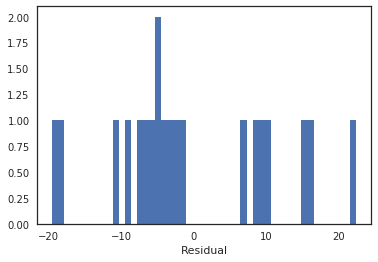

In [6]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

Deeper is not more powerful. Let's try with 1 hidden layer.

# A Shallowly Big Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 100000)            200000    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 100001    
Total params: 300,001
Trainable params: 300,001
Non-trainable params: 0
_________________________________________________________________
Train on 20 samples, validate on 20 samples
Epoch 1/500
20/20 [==============================] - 0s 8ms/step - loss: 186.0113 - val_loss: 132.0165
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 131.5768 - val_loss: 124.7024
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 121.8142 - val_loss: 120.1799
Epoch 4/500
20/20 [============================

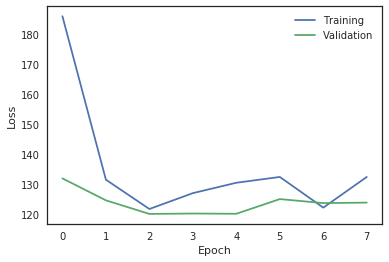

In [7]:
inputs = Input(shape=(1,))
hidden = Dense(100000, activation='relu')(inputs)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=500, batch_size=2, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

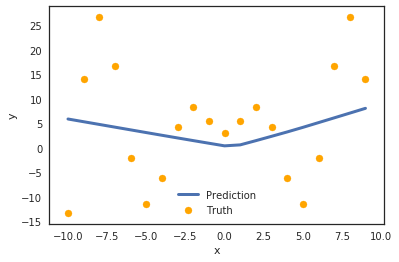

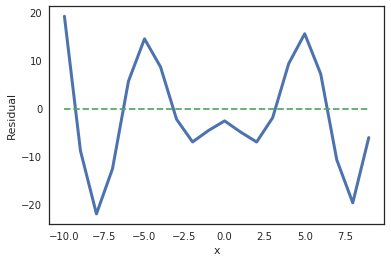

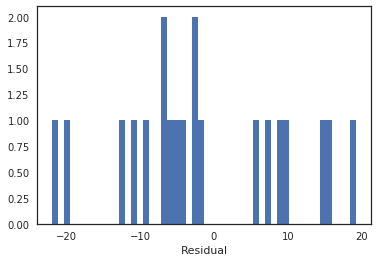

In [8]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

Shallowness doesn't help either. Universal approximation theorem, where are you?

OK I will stop kidding. The real reason, as you might have guessed, is early stopping. In high dimension it's more difficult to navigate to another minimum, therefore any kind of early stopping is undesirable when the network is still struggling to get from one local minimum to another.

# A Big Network Running for Eternity 

W0729 10:21:51.426178 140448506152768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 10:21:51.533587 140448506152768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 10:21:51.539444 140448506152768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 10:21:51.583650 140448506152768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             20000     
_________________________________________________________________
dense_2 (Dense)              (None, 10000)             100010000 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10001     
Total params: 100,040,001
Trainable params: 100,040,001
Non-trainable params: 0
_________________________________________________________________


W0729 10:21:51.847792 140448506152768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0729 10:21:51.960531 140448506152768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



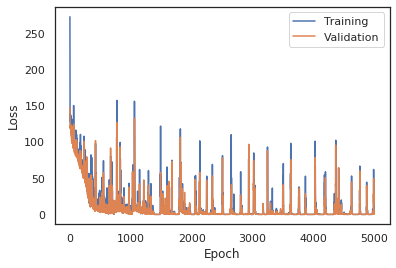

In [3]:
inputs = Input(shape=(1,))
hidden = Dense(10000, activation='relu')(inputs)
hidden = Dense(10000, activation='relu')(hidden)
#hidden = Dense(10, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=5000, batch_size=2, verbose=0, 
          #callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

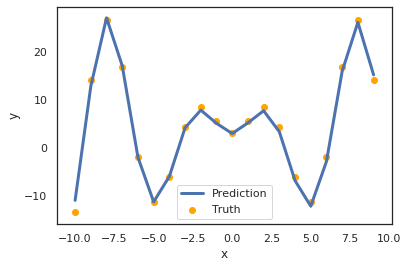

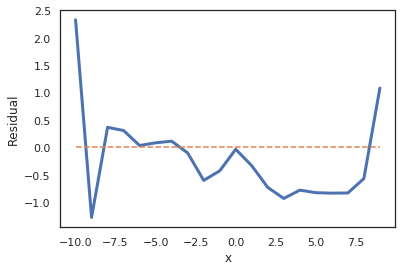

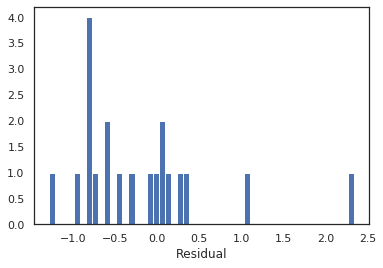

In [4]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

Even with a superduper big NNs, it only converges around epoch 500. Looking at the level of fluctuation in the loss history, any common choice of early stopping (3, 5, 10, 20) will not do us any good.

Now how about we do a resonably smaller network?

# A Small Network Running For Eternity

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_15 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


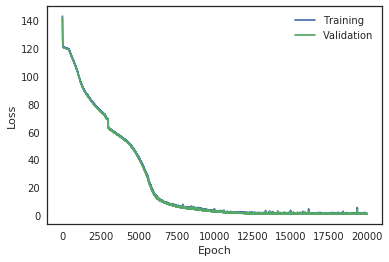

In [11]:
inputs = Input(shape=(1,))
hidden = Dense(10, activation='relu')(inputs)
hidden = Dense(10, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=20000, batch_size=2, verbose=0, 
          #callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

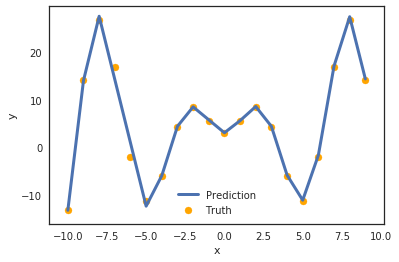

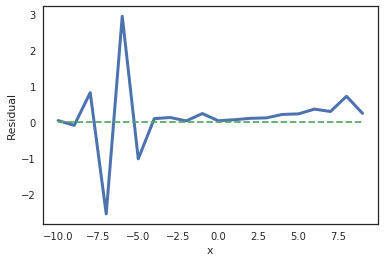

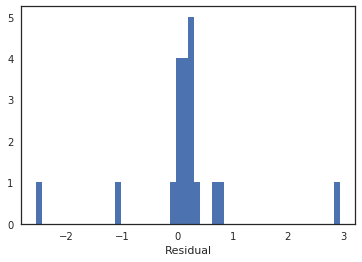

In [12]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

A network of 140 parameters can't overfit 20 data points until 10K epochs! Stick this to the face of whoever claims that number of parameters/number of datapoints ~ 0.1 or 10 or whatever is "reasonable".

A (literally) old friend of mine suspects that the slow convergence might come from using minibatch of size 2. Let's try to run only 1 batch of all 20 data points per epoch. 

# Just GD -- No SGD

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


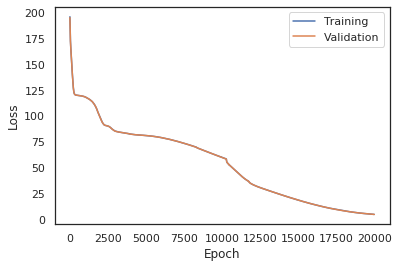

In [4]:
inputs = Input(shape=(1,))
hidden = Dense(10, activation='relu')(inputs)
hidden = Dense(10, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=20000, batch_size=20, verbose=0, 
          #callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

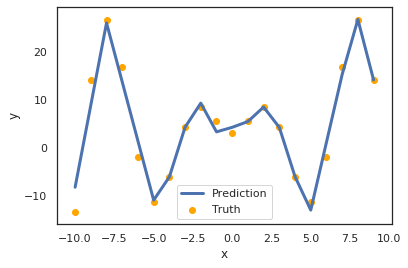

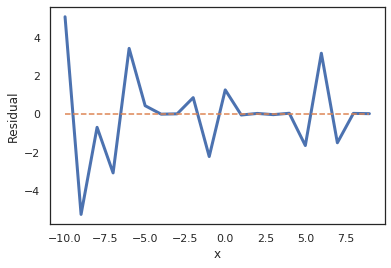

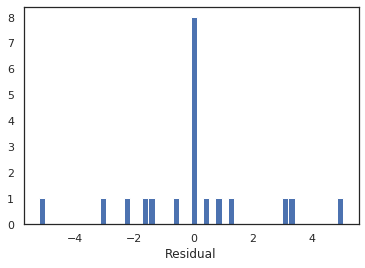

In [5]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

It's not even fully converged at epoch 20000! Which makes sense, because in theory stochastic gradient descent converges faster than just gradient descent as there are more gradient updates per epoch.

Looking back at the data, it's not hard to understand why the networks take so long to overfit. The data is deliberately made to look like noise, so even a human will just fit a straight line through it, ie, similar to the solution offered by early-stopped NNs where they look like it's the optimal solution until very later on. 

Therefore, a natural question pops out: What if I generate more data to make it more obviously a smooth function -- Can the network converge to the obvious correct solution right away? 

# Smoother Data

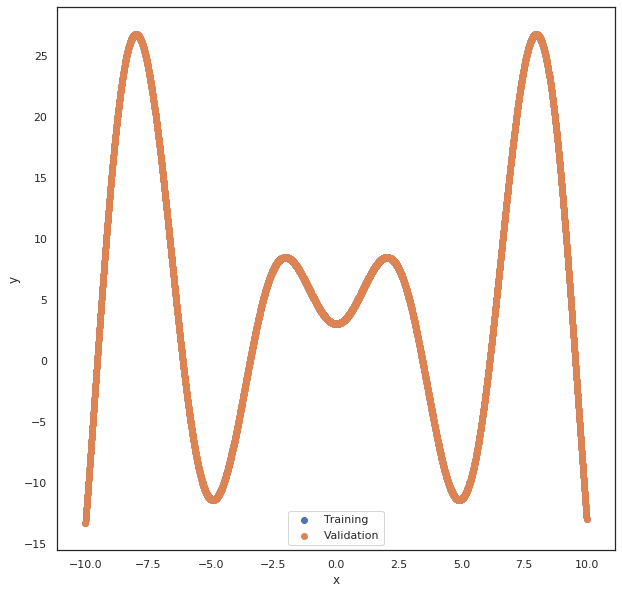

Number of data points:  2000


In [2]:
x = np.arange(-10,10, step=0.01)
y = 3+3*x * np.sin(x)
yval = y  # + np.random.normal(0,np.absolute(x/3))
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
plt.figure(figsize=(10,10))
plt.scatter(x,y,label='Training')
plt.scatter(x,yval,label='Validation')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

I will try early stopping on this first

W0804 14:26:46.246935 140513344837440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 14:26:46.262530 140513344837440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 14:26:46.265939 140513344837440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 14:26:46.311125 140513344837440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 14:26:46.460649 140513344837440 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


W0804 14:26:46.566486 140513344837440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



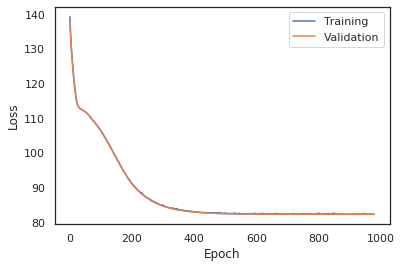

In [3]:
inputs = Input(shape=(1,))
hidden = Dense(10, activation='relu')(inputs)
hidden = Dense(10, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=10000, batch_size=200, verbose=0, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

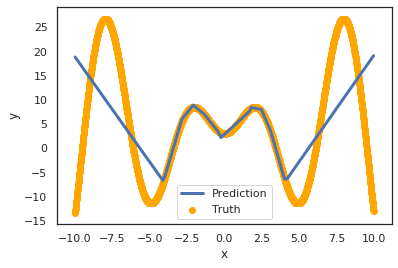

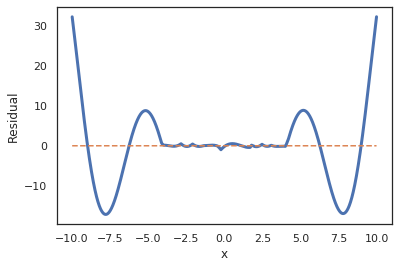

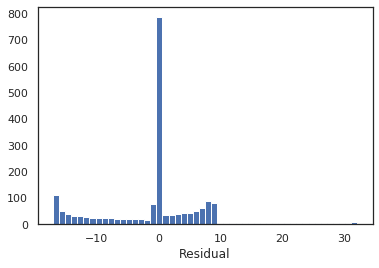

In [4]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

Looking at the loss history, we might think that it's really converged, but the results clearly inidicates that it's not. Now I'll retrain with 20k epochs, no early stopping.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


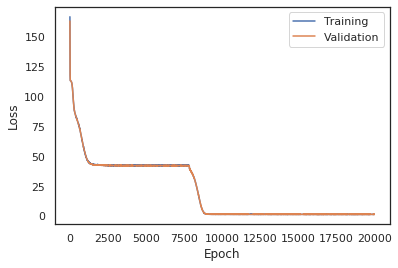

In [5]:
inputs = Input(shape=(1,))
hidden = Dense(10, activation='relu')(inputs)
hidden = Dense(10, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss="mse", optimizer='adam')
model.summary()

history = model.fit(x_train,y_train,  epochs=20000, batch_size=200, verbose=0, 
          #callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
          validation_data=(x,yval))

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

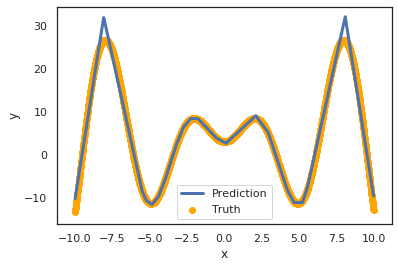

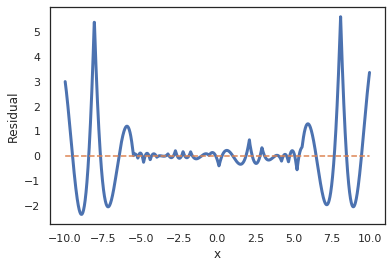

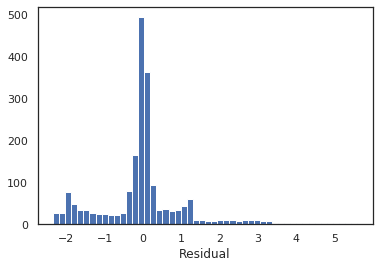

In [6]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=1)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

Wow. Insane! It's plateau for ~6000 epochs and then drops!

# Takeaway Messages
- Overfitting is possible but NOT easy, even with insanely large NNs.
- Larger NNs will have more fluctuation in terms of loss (due to the curse of dimensionality) -- Don't use early stopping and try to look at the loss history to see if it really converges.
- Smaller NNs have a more stable decreasing loss function but it's also much slower to converge.